## Accessing NAIP data with the Planetary Computer STAC API

In [5]:
from pystac_client import API
import planetary_computer as pc

Define our area of interest. This area is in Redmond, around Microsoft's main campus.

In [6]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.13254213333131, 47.63498833648423],
            [-122.12048292160033, 47.63498833648423],
            [-122.12048292160033, 47.64269456471515],
            [-122.13254213333131, 47.64269456471515],
            [-122.13254213333131, 47.63498833648423],
        ]
    ],
}

We'll search for imagery in both 2013 and 2019 separately to see what's changed over the years:

In [66]:
year_2013 = "2013-01-01/2013-12-31"
year_2019 = "2019-01-01/2019-12-31"

Use [pystac_client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data in June of 2020.

In [67]:
api = API.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [68]:
search_2013 = api.search(
    collections=['naip'], 
    intersects=area_of_interest, 
    datetime=year_2013  
)

search_2019 = api.search(
    collections=['naip'], 
    intersects=area_of_interest, 
    datetime=year_2019    
)
print(f"{search_2013.matched()} Items found for 2013")
print(f"{search_2019.matched()} Items found for 2019")

2 Items found for 2013
2 Items found for 2019


As seen above, there are two items that intersect our area of interest for each year. The following code will choose the item that has the most overlap:

In [69]:
from shapely.geometry import shape

In [71]:
area_shape = shape(area_of_interest)
target_area = area_shape.area
def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    
    return overlap_area / target_area

In [72]:
item_2013 = sorted(search_2013.items(), key=area_of_overlap, reverse=True)[0]
item_2019 = sorted(search_2019.items(), key=area_of_overlap, reverse=True)[0]

We can now render our images. The following code uses rasterio to render the image clipped to the bounding box of our area of interest. Notice the usage of `pc.sign` - this provides a version of the URL to the image that has a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) attached to it, which allows us to use the HREF in tooling that expects a publicly accessible URL.

In [26]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [51]:
def create_image(item):
    print(item.datetime)
    href = pc.sign(item.assets['image'].href)
    with rasterio.open(href) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(indexes=[1,2,3], window=aoi_window)

    return Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))

We can then view the 2013 image....

2013-09-10 00:00:00+00:00


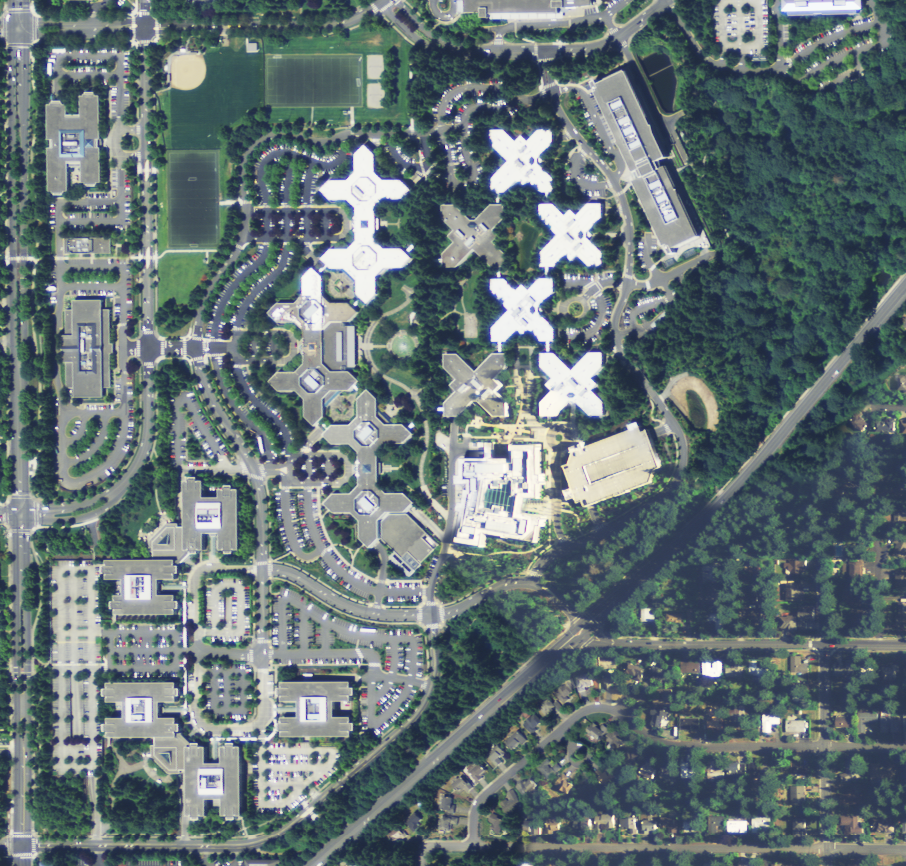

In [64]:
create_image(
   item_2013
)

..and the 2019 image, which looks quite different!

2019-10-11 00:00:00+00:00


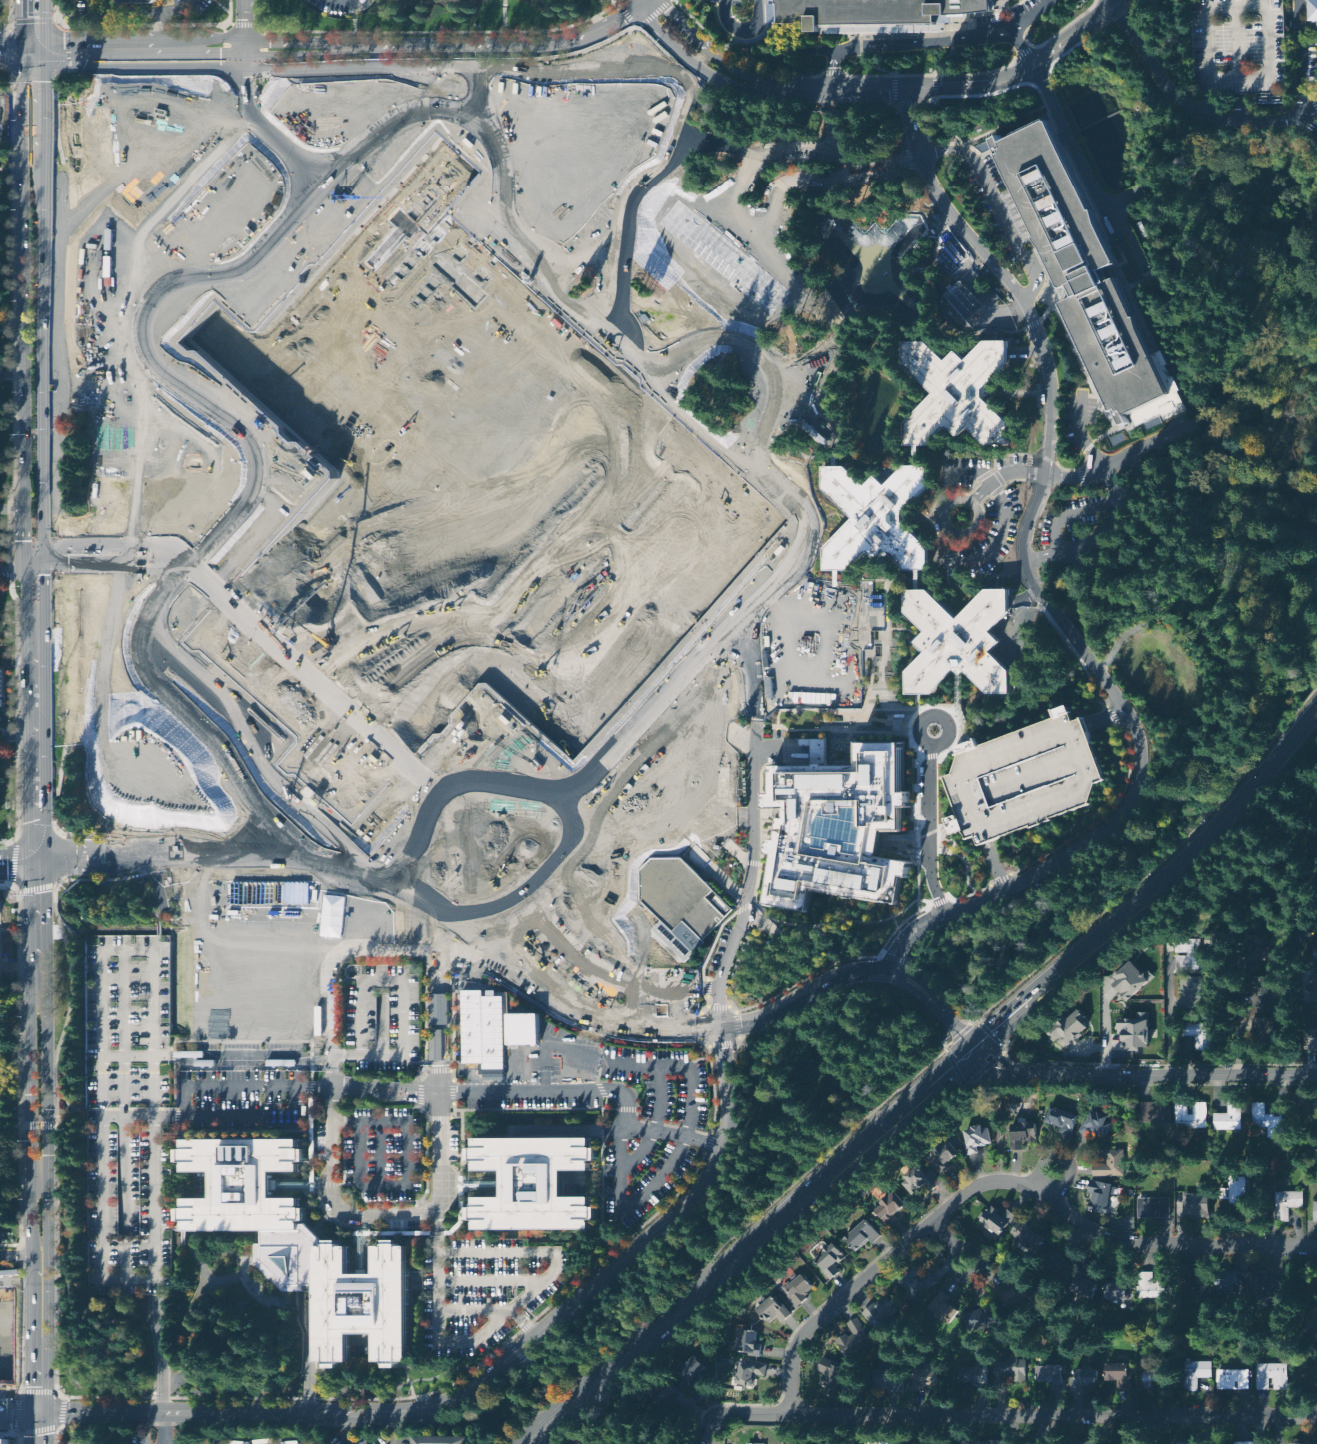

In [65]:
create_image(item_2019)

This shows the changes happening as part of the [Redmond campus modernization project](https://news.microsoft.com/2019/09/23/microsoft-redmond-campus-modernization-construction-update/).